In [1]:
% Initialize COBRA
initCobraToolbox



      _____   _____   _____   _____     _____     |
     /  ___| /  _  \ |  _  \ |  _  \   / ___ \    |   COnstraint-Based Reconstruction and Analysis
     | |     | | | | | |_| | | |_| |  | |___| |   |   The COBRA Toolbox - 2024
     | |     | | | | |  _  { |  _  /  |  ___  |   |
     | |___  | |_| | | |_| | | | \ \  | |   | |   |   Documentation:
     \_____| \_____/ |_____/ |_|  \_\ |_|   |_|   |   http://opencobra.github.io/cobratoolbox
                                                  | 

 > Checking if git is installed ...  Done (version: 2.39.3).
 > Checking if the repository is tracked using git ...  Done.
 > Checking if curl is installed ...  Done.
 > Checking if remote can be reached ...  Done.
 > Initializing and updating submodules (this may take a while)... Done.
 > Adding all the files of The COBRA Toolbox ...  Done.
 > Define CB map output... set to svg.
> In getDefinedFieldProperties (line 152)
In initCobraToolbox (line 352)

> In initCobraToolbox (line 377)
 > Config

In [2]:
cd('/Users/pablodigiusto/Documents/GitHub/Whole-Cell-Network-Reconstruction-for-CHO-cells/Notebooks');
addpath('/Users/pablodigiusto/Documents/GitHub/Whole-Cell-Network-Reconstruction-for-CHO-cells/Notebooks/Matlab code');

In [3]:
% Load iCHO3000 model
model = readCbModel('iCHOv3_CHO_03042024.mat');

Each model.subSystems{x} is a character array, and this format is retained.


In [4]:
% Create a dictionary with the gene names of our model as keys and the gene IDs as values

genes = model.genes; % or model.rxns or another field depending on your model
geneNames = model.geneNames; % Adjust field name as per your model's structure

% Initialize a map (dictionary) to hold gene names as keys and genes IDs as values
geneDict = containers.Map('KeyType', 'char', 'ValueType', 'char');

% Iterate over the genes
for i = 1:length(genes)
    geneID = genes{i};
    geneName = geneNames{i};
    geneDict(geneName) = geneID; % Use gene name as key, gene ID as value
end

In [5]:
% Loading the RNA-seq data
dataTable = readtable('../Data/Zela Data/20200307_Bio141-148_merged.tpm.tsv', 'FileType', 'text', 'Delimiter', '\t');

% Extracting gene names if the first column
geneNames = dataTable{:, 1};

% Map gene IDs from the model to the RNA-Seq data
for i = 1:length(geneNames)
    currentGeneName = geneNames{i};
    if isKey(geneDict, currentGeneName)
        % If the current gene name exists in the dictionary, replace it with the gene ID
        updatedGeneNames{i} = geneDict(currentGeneName);
    else
        % If the gene name does not exist in the dictionary, keep the original name
        updatedGeneNames{i} = currentGeneName;
    end
end

% Calculate mean expression across replicates for simplicity
expressionWT = mean(table2array(dataTable(:, 2:18)), 2); % Mean across WT replicates - THIS IS WRONG NEEDS TO BE FIXED
expressionZeLa = mean(table2array(dataTable(:, 19:end)), 2); % Mean across ZeLa replicates  - THIS IS WRONG NEEDS TO BE FIXED
expressionDataMatrix = [expressionWT, expressionZeLa]; % Combine into a single matrix

% Condition Names
cellNames = {'WT', 'ZeLa'}; % Adjust as needed

% Creating the expressionData Structure
expressionData = struct;
expressionData.gene = updatedGeneNames;
expressionData.valuebyTissue = expressionDataMatrix;
expressionData.Tissue = cellNames;

% Conditions:
% WT_P2 (S01,S07,S13)
% WT_P4 
% WT_P6
% WT_P8
% WT_P12
% WT_P14

% ZeLa_P2 (S22, S27, S33, S38)
% ZeLa_P4
% ZeLa_P6
% ZeLa_P8
% ZeLa_P12
% ZeLa_P14

In [6]:
% extract expression data of the genes in the model
modelData = getModelData(expressionData,model);

In [7]:
modelData


modelData = 

  struct with fields:

              gene: {1x3434 cell}
            Tissue: {'WT'  'ZeLa'}
             value: [3434x2 double]
    ID_geneMissing: {210x1 cell}
    ID_genePresent: {3434x1 cell}



In [8]:
% Calculate enzymes in the model
spec = getSpecialistEnzymes(model);  
prom = getPromEnzymes(model);

> In comparePromiscuousSpecific (line 32)

> In comparePromiscuousSpecific (line 32)



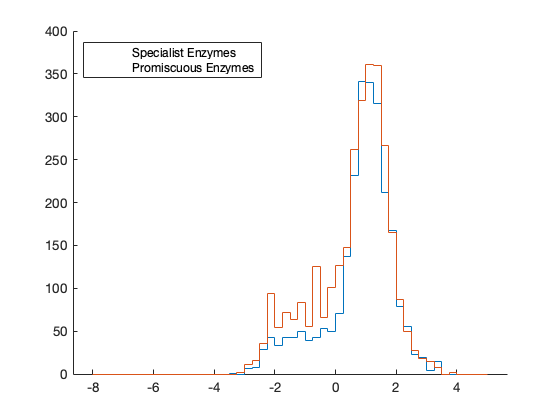

In [9]:
% Calculate enzyme expression
enzymeData = comparePromiscuousSpecific(spec,prom,modelData);

In [10]:
edgeX = [-2 -1 0 1 2 2.5 3 4]; % bins  

In [11]:
k = 3


k =

     3



In [12]:
distMethod = 'euclidean'; % distance method  

In [13]:
linkageMethod = 'complete'; % linkage metric for hierarchical clustering

Cophenetic correlation coeffcient using complete linkage and euclidean distance = 0.9484


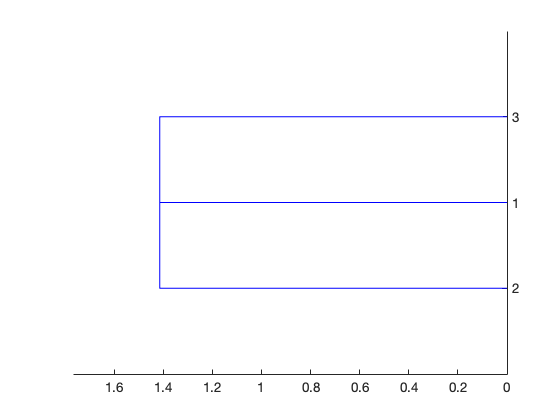

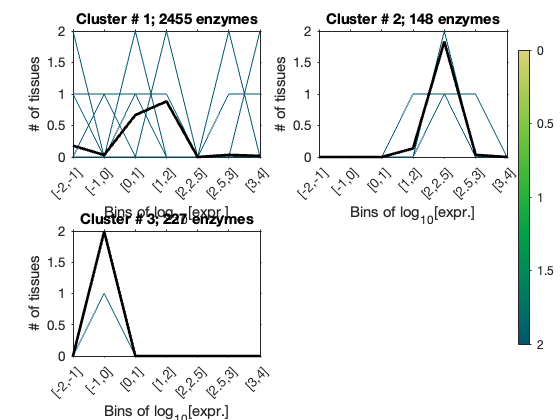

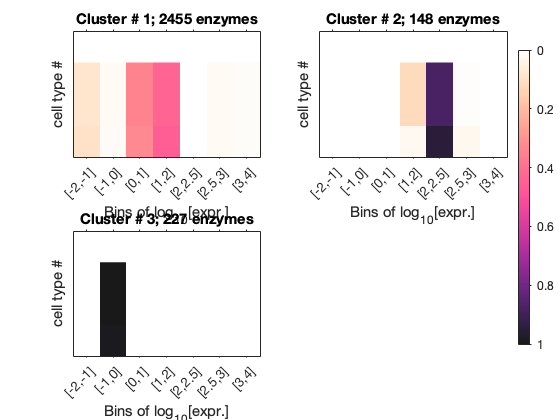

In [14]:
% Calculate clusters of enzyme expression
clustObj = geneExprDist_hierarchy(enzymeData,[],edgeX,k,distMethod,linkageMethod);